# Compare CW3E and NLDAS2


Runs a comparison between CW3E and NLDAS2 in the following steps:
1) Reads in CONUS1 NLDAS2 forcing data
2) Reads in CONUS2 CW3E forcing data
3) Reads in metadata for CONUS1 SNOTEL sites
4) Performs comparison by subtracting CW3E-NLDAS2 temp each day, and takes the avg (same outputs as second method, which finds annual avg temp and then takes difference)
5) Plots results on CONUS1 domain

In [20]:
import sys
from parflow.tools.io import read_pfb,write_pfb
import numpy as np
import pandas as pd

##### Change paths to directories, run information...

In [21]:
### Directory to save CSV outputs
C1_organized_dir = '/home/ad4430/for_ashley/precip_temp_CONUS1/Organized_csv/temperature' # verde
C2_organized_dir = '/home/ad4430/for_ashley/precip_temp/Organized_csv/temperature' # verde

### Where you want to save plots, etc. to
plot_dir = '/home/ad4430/for_ashley/precip_temp_CONUS1/Figures' # verde
print(f'Figures saving to: {plot_dir}')

### need to change water year and number of days
water_year = 2006
no_days = 365
variable = 'Temp_C'

### CONUS1 domain
ny = 1888
nx = 3342

Figures saving to: /home/ad4430/for_ashley/precip_temp_CONUS1/Figures


# 1. Read C1 NLDAS2 forcing

### Note files say CW3E, should be labeled NLDAS2 for C1 files

In [22]:
C1_pf_match_csv = f'CW3E_Daily_matched_CONUS1_{variable}_{water_year}.csv'

In [23]:
NLDAS2_df = pd.read_csv(f'{C1_organized_dir}/{C1_pf_match_csv}')
NLDAS2_df

,site_id,2005-10-01,2005-10-02,2005-10-03,2005-10-04,2005-10-05,2005-10-06,2005-10-07,2005-10-08,2005-10-09,...,2006-09-21,2006-09-22,2006-09-23,2006-09-24,2006-09-25,2006-09-26,2006-09-27,2006-09-28,2006-09-29,2006-09-30
0,916:MT:SNTL,10.511874,10.764712,10.169584,10.511046,7.976297,3.164687,5.587587,8.504273,6.114545,...,3.560261,1.833294,-0.231028,2.386119,4.105114,5.855082,6.392852,6.356358,8.683220,9.619072
1,305:CO:SNTL,13.646116,10.238575,5.437336,3.447202,1.483171,4.035724,8.145301,7.098919,3.757036,...,7.519273,4.266009,4.105400,6.291124,7.817742,9.876508,11.581909,13.027161,12.701435,13.453434
2,306:ID:SNTL,11.396736,4.344696,1.003530,-1.237727,-2.263542,0.627172,5.131396,3.674487,1.362625,...,4.283832,0.828991,1.574033,5.738409,7.848225,9.043068,6.229532,8.577943,11.063024,11.602972
3,307:MT:SNTL,11.842092,4.791717,1.471658,-0.762935,-1.777488,1.102934,5.553597,4.128306,1.829518,...,4.705164,1.254605,2.021989,6.145241,8.303645,9.463505,6.705756,9.032076,11.494585,11.998039
4,309:WY:SNTL,13.337083,12.498369,8.365288,4.093905,2.055814,1.744597,5.164791,8.987341,4.521946,...,5.380141,3.248441,3.522591,5.699307,7.700245,9.584323,10.734684,11.761577,12.391117,13.057647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,808:MT:SCAN,15.953536,12.375152,6.639061,3.035434,-1.315492,-0.688437,5.444008,8.598840,5.184476,...,7.858761,4.617363,5.021186,6.845199,10.045646,11.713055,10.706681,11.124312,14.080848,14.624536
408,2091:AR:SCAN,7.951245,4.603114,4.426874,2.290501,3.222125,8.399672,8.033618,4.655649,4.957872,...,5.597241,5.183061,6.125255,9.018087,11.421046,12.539456,13.923160,14.476441,14.292432,14.528164
409,2090:AR:SCAN,11.405124,8.347939,8.126438,5.910644,6.659736,11.808682,11.712245,8.320970,8.677273,...,9.158331,8.695929,9.726149,12.685213,14.995587,16.105143,17.380542,18.091837,17.947909,18.134161
410,2108:NM:SCAN,5.570286,2.460799,2.782149,2.841442,3.224547,4.171725,4.194247,2.950165,4.009648,...,4.210807,4.529983,5.356096,8.060454,10.810918,11.309691,10.824731,12.273697,12.834880,11.866949


In [24]:
NLDAS2_df = NLDAS2_df.set_index('site_id')
NLDAS2_df 

,2005-10-01,2005-10-02,2005-10-03,2005-10-04,2005-10-05,2005-10-06,2005-10-07,2005-10-08,2005-10-09,2005-10-10,...,2006-09-21,2006-09-22,2006-09-23,2006-09-24,2006-09-25,2006-09-26,2006-09-27,2006-09-28,2006-09-29,2006-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
916:MT:SNTL,10.511874,10.764712,10.169584,10.511046,7.976297,3.164687,5.587587,8.504273,6.114545,0.077750,...,3.560261,1.833294,-0.231028,2.386119,4.105114,5.855082,6.392852,6.356358,8.683220,9.619072
305:CO:SNTL,13.646116,10.238575,5.437336,3.447202,1.483171,4.035724,8.145301,7.098919,3.757036,2.846876,...,7.519273,4.266009,4.105400,6.291124,7.817742,9.876508,11.581909,13.027161,12.701435,13.453434
306:ID:SNTL,11.396736,4.344696,1.003530,-1.237727,-2.263542,0.627172,5.131396,3.674487,1.362625,1.667235,...,4.283832,0.828991,1.574033,5.738409,7.848225,9.043068,6.229532,8.577943,11.063024,11.602972
307:MT:SNTL,11.842092,4.791717,1.471658,-0.762935,-1.777488,1.102934,5.553597,4.128306,1.829518,2.138208,...,4.705164,1.254605,2.021989,6.145241,8.303645,9.463505,6.705756,9.032076,11.494585,11.998039
309:WY:SNTL,13.337083,12.498369,8.365288,4.093905,2.055814,1.744597,5.164791,8.987341,4.521946,3.352964,...,5.380141,3.248441,3.522591,5.699307,7.700245,9.584323,10.734684,11.761577,12.391117,13.057647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808:MT:SCAN,15.953536,12.375152,6.639061,3.035434,-1.315492,-0.688437,5.444008,8.598840,5.184476,3.935079,...,7.858761,4.617363,5.021186,6.845199,10.045646,11.713055,10.706681,11.124312,14.080848,14.624536
2091:AR:SCAN,7.951245,4.603114,4.426874,2.290501,3.222125,8.399672,8.033618,4.655649,4.957872,5.963539,...,5.597241,5.183061,6.125255,9.018087,11.421046,12.539456,13.923160,14.476441,14.292432,14.528164
2090:AR:SCAN,11.405124,8.347939,8.126438,5.910644,6.659736,11.808682,11.712245,8.320970,8.677273,9.411600,...,9.158331,8.695929,9.726149,12.685213,14.995587,16.105143,17.380542,18.091837,17.947909,18.134161


# 2. Read in CW3E Forcing and organize

In [25]:
C2_pf_match_csv = f'CW3E_Daily_matched_CONUS2_Temp_C_{water_year}.csv'

In [26]:
CW3E_df = pd.read_csv(f'{C2_organized_dir}/{C2_pf_match_csv}')
CW3E_df

,site_id,2005-10-01,2005-10-02,2005-10-03,2005-10-04,2005-10-05,2005-10-06,2005-10-07,2005-10-08,2005-10-09,...,2006-09-21,2006-09-22,2006-09-23,2006-09-24,2006-09-25,2006-09-26,2006-09-27,2006-09-28,2006-09-29,2006-09-30
0,301:CA:SNTL,12.892731,3.586350,0.520670,-0.449802,1.077119,4.588270,8.208253,5.665407,3.840028,...,5.666065,3.245070,5.134587,8.783322,9.502983,10.893835,12.522138,13.643060,13.986471,14.670145
1,916:MT:SNTL,15.116781,13.950716,7.078291,2.818347,0.790425,2.692761,8.791344,12.609411,4.656089,...,3.847826,6.329042,1.181155,4.940254,8.805255,11.613072,13.458102,13.627569,14.673926,15.054489
2,908:WA:SNTL,11.906825,9.674380,0.930948,-0.416822,-4.131480,-1.627233,0.256587,4.177696,0.224021,...,3.561870,3.434351,-0.708898,3.392311,5.663638,7.687290,6.531323,5.470466,9.547825,9.498834
3,1000:OR:SNTL,11.065472,4.763695,0.655758,0.985493,1.707258,5.464325,7.075052,4.591172,3.907529,...,6.700244,6.317546,5.505155,9.238373,11.946731,14.013775,15.297717,16.630027,16.892928,17.891417
4,305:CO:SNTL,8.797011,10.467353,10.730625,12.098547,7.936857,1.254376,3.549711,7.250934,9.381682,...,7.236078,1.552143,0.612618,0.501211,3.065707,4.438992,6.091449,6.348725,8.287946,9.597646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,2091:AR:SCAN,13.658460,6.956280,2.779100,1.530314,1.270105,2.298509,6.199903,8.284912,4.364548,...,4.847775,3.727736,5.150209,4.909132,7.474631,10.099217,11.216355,13.434768,13.453770,13.599144
487,2090:AR:SCAN,16.933509,9.852136,6.044672,4.622031,4.760890,7.151277,9.901345,11.012830,10.031638,...,9.080618,7.610517,7.965785,10.903598,12.781953,15.595680,17.509208,18.816499,19.718097,19.597744
488,2026:AZ:SCAN,8.519266,2.871037,1.237764,1.007239,1.817309,3.250307,3.219534,2.978241,2.989620,...,5.163052,4.623928,6.414592,8.132450,10.110208,11.548034,12.705118,12.581454,14.112412,13.955610
489,2108:NM:SCAN,5.887607,2.689597,2.960092,2.280856,3.690262,4.573136,5.302897,3.330826,3.760667,...,5.652616,5.084400,7.874521,10.888870,12.481350,13.906112,13.949408,14.135805,13.897437,12.724477


In [27]:
CW3E_df = CW3E_df.set_index('site_id')
CW3E_df

,2005-10-01,2005-10-02,2005-10-03,2005-10-04,2005-10-05,2005-10-06,2005-10-07,2005-10-08,2005-10-09,2005-10-10,...,2006-09-21,2006-09-22,2006-09-23,2006-09-24,2006-09-25,2006-09-26,2006-09-27,2006-09-28,2006-09-29,2006-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
301:CA:SNTL,12.892731,3.586350,0.520670,-0.449802,1.077119,4.588270,8.208253,5.665407,3.840028,5.823338,...,5.666065,3.245070,5.134587,8.783322,9.502983,10.893835,12.522138,13.643060,13.986471,14.670145
916:MT:SNTL,15.116781,13.950716,7.078291,2.818347,0.790425,2.692761,8.791344,12.609411,4.656089,2.621732,...,3.847826,6.329042,1.181155,4.940254,8.805255,11.613072,13.458102,13.627569,14.673926,15.054489
908:WA:SNTL,11.906825,9.674380,0.930948,-0.416822,-4.131480,-1.627233,0.256587,4.177696,0.224021,0.995842,...,3.561870,3.434351,-0.708898,3.392311,5.663638,7.687290,6.531323,5.470466,9.547825,9.498834
1000:OR:SNTL,11.065472,4.763695,0.655758,0.985493,1.707258,5.464325,7.075052,4.591172,3.907529,4.738566,...,6.700244,6.317546,5.505155,9.238373,11.946731,14.013775,15.297717,16.630027,16.892928,17.891417
305:CO:SNTL,8.797011,10.467353,10.730625,12.098547,7.936857,1.254376,3.549711,7.250934,9.381682,2.050405,...,7.236078,1.552143,0.612618,0.501211,3.065707,4.438992,6.091449,6.348725,8.287946,9.597646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091:AR:SCAN,13.658460,6.956280,2.779100,1.530314,1.270105,2.298509,6.199903,8.284912,4.364548,4.015518,...,4.847775,3.727736,5.150209,4.909132,7.474631,10.099217,11.216355,13.434768,13.453770,13.599144
2090:AR:SCAN,16.933509,9.852136,6.044672,4.622031,4.760890,7.151277,9.901345,11.012830,10.031638,9.097765,...,9.080618,7.610517,7.965785,10.903598,12.781953,15.595680,17.509208,18.816499,19.718097,19.597744
2026:AZ:SCAN,8.519266,2.871037,1.237764,1.007239,1.817309,3.250307,3.219534,2.978241,2.989620,4.239980,...,5.163052,4.623928,6.414592,8.132450,10.110208,11.548034,12.705118,12.581454,14.112412,13.955610


In [28]:
# change C2 df to only include C1 SNOTEL sites
CW3E_df= CW3E_df[CW3E_df.index.isin(NLDAS2_df.index)]
CW3E_df

,2005-10-01,2005-10-02,2005-10-03,2005-10-04,2005-10-05,2005-10-06,2005-10-07,2005-10-08,2005-10-09,2005-10-10,...,2006-09-21,2006-09-22,2006-09-23,2006-09-24,2006-09-25,2006-09-26,2006-09-27,2006-09-28,2006-09-29,2006-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
916:MT:SNTL,15.116781,13.950716,7.078291,2.818347,0.790425,2.692761,8.791344,12.609411,4.656089,2.621732,...,3.847826,6.329042,1.181155,4.940254,8.805255,11.613072,13.458102,13.627569,14.673926,15.054489
305:CO:SNTL,8.797011,10.467353,10.730625,12.098547,7.936857,1.254376,3.549711,7.250934,9.381682,2.050405,...,7.236078,1.552143,0.612618,0.501211,3.065707,4.438992,6.091449,6.348725,8.287946,9.597646
306:ID:SNTL,10.694749,12.776343,14.479681,12.996918,5.301200,1.045600,2.159186,7.558148,10.594991,1.905350,...,9.261732,2.179047,2.194480,2.475122,5.192832,6.464103,8.562096,8.301286,9.590888,11.720182
307:MT:SNTL,12.607052,8.861650,3.759477,1.211833,1.890353,3.473315,5.679433,7.770836,6.833631,5.510472,...,8.398304,8.134929,6.919302,6.967650,8.655342,10.847375,11.225277,12.110199,13.069077,13.064100
309:WY:SNTL,6.364605,7.999932,9.225537,9.842531,3.523372,-3.067713,-0.035455,4.083866,6.121889,-2.188507,...,3.293626,-2.834167,-3.340563,-3.229351,-0.690507,0.813000,2.960467,3.724718,5.304329,6.678318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808:MT:SCAN,6.983414,8.768508,8.794982,10.113964,4.827259,-0.180935,1.564956,5.315752,7.999593,-0.059131,...,4.896093,-1.407413,-1.811438,-2.241134,0.436486,2.040943,3.883558,4.377569,6.499451,7.736354
2091:AR:SCAN,13.658460,6.956280,2.779100,1.530314,1.270105,2.298509,6.199903,8.284912,4.364548,4.015518,...,4.847775,3.727736,5.150209,4.909132,7.474631,10.099217,11.216355,13.434768,13.453770,13.599144
2090:AR:SCAN,16.933509,9.852136,6.044672,4.622031,4.760890,7.151277,9.901345,11.012830,10.031638,9.097765,...,9.080618,7.610517,7.965785,10.903598,12.781953,15.595680,17.509208,18.816499,19.718097,19.597744


# 3. Metadata for coords

In [29]:
metadata_df = pd.read_csv(f'{C1_organized_dir}/Hydrodata_temperature_metadata_daily_average_WY{water_year}.csv')
metadata_df = metadata_df.drop(columns = ['Unnamed: 0'])
metadata_df = metadata_df.set_index('site_id')
metadata_df = metadata_df[metadata_df.index.isin(NLDAS2_df.index)]
metadata_df

,site_type,agency,site_name,site_id_agency,site_query_url,date_metadata_last_updated,latitude,longitude,state,huc,...,latest_download_date,file_path,county_name,elevation,shef_id,acton_id,conus1_x,conus1_y,conus2_x,conus2_y
site_id,,,,,,,,,,,,,,,,,,,,,
1005:CO:SNTL,SNOTEL station,NRCS,Ute Creek,1005:CO:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,37.61480,-105.37322,CO,130100020604,...,2023-07-09,/hydrodata/national_obs/point_meteorology/NRCS...,Costilla,10734.0,UTCC2,05M17S,1063.0,495.0,1490,1448
1006:NV:SNTL,SNOTEL station,NRCS,Lewis Peak,1006:NV:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,40.35720,-116.86470,NV,160401070903,...,2023-07-09,/hydrodata/national_obs/point_meteorology/NRCS...,Lander,7370.0,LWPN2,16J01S,137.0,957.0,592,1908
1008:MT:SNTL,SNOTEL station,NRCS,Onion Park,1008:MT:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.91348,-110.85360,MT,100301030801,...,2023-07-09,/hydrodata/national_obs/point_meteorology/NRCS...,Meagher,7410.0,ONPM8,10C22S,753.0,1575.0,1196,2499
1009:MT:SNTL,SNOTEL station,NRCS,Stringer Creek,1009:MT:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.92690,-110.90198,MT,100301030801,...,2023-07-09,/hydrodata/national_obs/point_meteorology/NRCS...,Meagher,6550.0,STCM8,10C23S,750.0,1577.0,1193,2501
1013:UT:SNTL,SNOTEL station,NRCS,Temple Fork,1013:UT:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,41.79300,-111.54605,UT,160102030303,...,2023-07-09,/hydrodata/national_obs/point_meteorology/NRCS...,Cache,7406.0,TPKU1,11H58S,604.0,1024.0,1047,1967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981:MT:SNTL,SNOTEL station,NRCS,Burnt Mtn,981:MT:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,45.24010,-109.45961,MT,100700060802,...,2023-07-09,/hydrodata/national_obs/point_meteorology/NRCS...,Carbon,5880.0,BMTM8,09D21S,831.0,1374.0,1269,2305
984:WA:SNTL,SNOTEL station,NRCS,Spruce Springs,984:WA:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.18287,-117.54155,WA,170601030201,...,2023-07-09,/hydrodata/national_obs/point_meteorology/NRCS...,Garfield,5700.0,SPGW1,17C04S,233.0,1598.0,697,2528
985:WA:SNTL,SNOTEL station,NRCS,Sourdough Gulch,985:WA:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.23718,-117.39438,WA,170601030202,...,2023-07-09,/hydrodata/national_obs/point_meteorology/NRCS...,Asotin,4000.0,SGUW1,17C06S,245.0,1601.0,709,2531


# 4. Performing comparison

In [30]:

# method 1: subtracting CW3E - NLDAS2 for each day, at each gage then taking avg
difference = np.zeros((len(CW3E_df.index), len(CW3E_df.columns)))
for g in range(len(CW3E_df.index)):
    gage = CW3E_df.index[g]
    for i in range(len(CW3E_df.columns)):
        day = CW3E_df.columns[i]
        difference[g][i] = CW3E_df.loc[gage][day]-NLDAS2_df.loc[gage][day]
    difference_df = pd.DataFrame(difference)
difference_df

# put gage and date headers in difference df
difference_df = difference_df.set_index(CW3E_df.index)
column_headers = list(CW3E_df.columns.values)
difference_df.columns = column_headers
difference_df

# method 2: taking yearly averages, then finding difference
avg_df = pd.DataFrame()
#indices = list(CW3E_df.index.values)
#avg_df.index = indices

avg_CW3E = np.zeros(len(CW3E_df.index))
avg_NLDAS2 = np.zeros(len(NLDAS2_df.index))
for g in range(len(CW3E_df.index)):
    gage = CW3E_df.index[g]
    avg_CW3E[g] = CW3E_df.loc[gage].sum()/len(CW3E_df.columns)
    avg_NLDAS2[g] = NLDAS2_df.loc[gage].sum()/len(NLDAS2_df.columns)


avg_df['CW3E temp'] = pd.Series(avg_CW3E)
avg_df['NLDAS2 temp'] = pd.Series(avg_NLDAS2)

avg_df

,CW3E temp,NLDAS2 temp
0,7.324438,2.855500
1,3.504622,5.202412
2,5.226235,2.305827
3,5.339482,2.745464
4,0.362074,5.275753
...,...,...
407,1.196214,5.991764
408,5.654117,5.942747
409,9.209436,9.491635
410,4.947860,3.547727


In [31]:
# mean difference
comparison_df = pd.DataFrame()
comparison_df['mean_diff'] = difference_df.sum(axis = 1)/365 # method 1 - taking daily difference first
comparison_df['annual_avg_diff'] = avg_CW3E - avg_NLDAS2 # method 2 - taking avg temp first

# adding metadata
comparison_df = comparison_df.join(metadata_df['conus1_x'])
comparison_df = comparison_df.join(metadata_df['conus1_y'])
#comparison_df['num_obs'] = metadata_df['num_obs']
comparison_df

,mean_diff,annual_avg_diff,conus1_x,conus1_y
site_id,,,,
916:MT:SNTL,4.468939,4.468939,644.0,1445.0
305:CO:SNTL,-1.697790,-1.697790,1056.0,751.0
306:ID:SNTL,2.920408,2.920408,350.0,1295.0
307:MT:SNTL,2.594018,2.594018,615.0,1738.0
309:WY:SNTL,-4.913679,-4.913679,950.0,1308.0
...,...,...,...,...
808:MT:SCAN,-4.795550,-4.795550,677.0,1463.0
2091:AR:SCAN,-0.288631,-0.288631,2312.0,95.0
2090:AR:SCAN,-0.282199,-0.282199,2164.0,191.0


# 5. Plotting Results

In [32]:
#from parflow.tools.io import read_pfb,write_pfb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
#import geopandas as gpd
from PIL import Image
from mpl_toolkits.basemap import Basemap as Basemap

In [33]:
plot_dir = '/home/ad4430/for_ashley/precip_temp_CONUS1/Figures/summary_plots_temp'

In [34]:
# Read in CONUS2 mask and HUC2 png for map plot border and HUC2 outlines
CONUS2_mask = Image.open('/hydrodata/PFCLM/CONUS2_baseline/inputs/domain_files/CONUS2.0.Final1km.Mask.tif')
mask_array = np.array(CONUS2_mask)
HUC2_outline = Image.open('/home/ad4430/for_ashley/precip_temp_CONUS1/Figures/CONUS1_HUCmap.png')

In [35]:
# # Read in CONUS2 mask for map plot border
# CONUS2_mask = Image.open('/hydrodata/PFCLM/CONUS2_baseline/inputs/domain_files/CONUS2.0.Final1km.Mask.tif')
# #CONUS2_mask = Image.open('/home/dtt2/CONUS2/shape_files/CONUS2_HUC2_boundaries_clipped.tif')
# mask_array = np.array(CONUS2_mask)

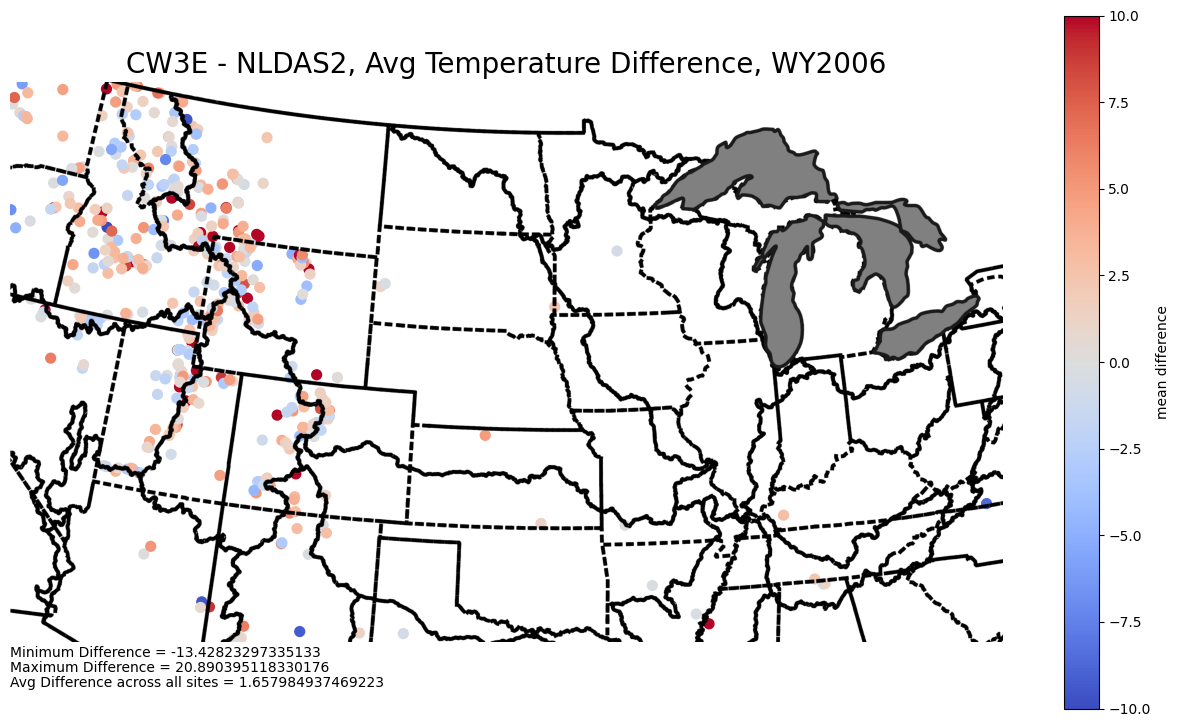

In [36]:
#
fig, ax = plt.subplots(1,1,figsize=(16,9))
im = ax.imshow(HUC2_outline, extent=[0, nx, 0, ny],zorder=2)
plt.scatter(comparison_df.conus1_x,comparison_df.conus1_y, c=comparison_df.mean_diff, cmap = 'coolwarm', s=50, vmin = -10, vmax = 10)
plt.colorbar(label='mean difference')
plt.axis('off')
plt.title(f'CW3E - NLDAS2, Avg Temperature Difference, WY{water_year}', fontsize = 20)
plt.text(0, -50, "Minimum Difference = " + str(comparison_df.mean_diff.min()))
plt.text(0, -100, "Maximum Difference = " + str(comparison_df.mean_diff.max()))
plt.text(0, -150, "Avg Difference across all sites = " + str(comparison_df.mean_diff.mean()))
plt.savefig(f'{plot_dir}/WY{water_year}_CW3E_minus_NLDAS2_{variable}_RelBias_Map.png',\
             dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")
#print(avg_bias)s